In [17]:
import numpy as np
import time
import sys

from mpmath import hyp1f1, gamma
import math

import matplotlib.pyplot as plt
from IPython.display import clear_output

In [29]:
############################################# My Models ##################################################

from mpmath import hyp1f1, gamma
import scipy
import math

G = 6.67430*1e-11 
c = 299792458. 
M_sun = 1.989*1e30

### Function Definitions ###
# image positions
def xm(y):
    return (y+np.sqrt(y**2+4))/2
def xs(y):
    return (y-np.sqrt(y**2+4))/2

#image magnifications
def um(y):
    return 1/2 + (y**2+2)/(2*y*np.sqrt(y**2+4))   
def us(y):
    return 1/2 - (y**2+2)/(2*y*np.sqrt(y**2+4))

#time delay between the two images
def td_pnt_dimensionless(y):
    return (y*np.sqrt(y**2+4))/2. + np.log((np.sqrt(y**2+4)+y)/(np.sqrt(y**2+4)-y))

def td_pnt_sec(mlz, y):
    return (4*G*M_sun*mlz/c**3)*((y*np.sqrt(y**2+4))/2. + np.log((np.sqrt(y**2+4)+y)/(np.sqrt(y**2+4)-y)))

# Geometric and Quasi Geometric approximations
def Fw_geo(w, y):
    return np.sqrt(np.abs(um(y))) - 1j*np.sqrt(np.abs(us(y)))*np.exp(1j*w*td_pnt_dimensionless(y))

def Fw_qgeo(w, y):
    return Fw_geo(w,y) + (1j/(3*w))*((4*xm(y)**2-1)/(pow((xm(y)**2+1),3)*(xm(y)**2-1)))*np.sqrt(np.abs(um(y))) + \
           (1/(3*w))*((4*xs(y)**2-1)/(pow((xs(y)**2+1),3)*(xs(y)**2-1)))*np.sqrt(np.abs(us(y)))*np.exp(1j*w*td_pnt_dimensionless(y)) 

# dimensionless frequency, w(f)
def wf(f, ml, zl=0):
    return f*8.*np.pi*G*ml*(1+zl)*M_sun/c**3.

def wc_geo_re0p1(y):
# returns wc(y) (cutoff w for a given y) such that w > wc gives relative error < 0.1 % when 
# geometric optics is used. Valid for y in range (0.01, 5.00)
    if y <= 0.12:
        wc = 15112.5 - 52563.5*y
    elif 0.12 < y <= 1.5:
        wc = -34.08 - 12.84*pow(y,-1) + 114.33*pow(y,-2) + 0.89*pow(y,-3) 
    elif y > 1.5:
        wc = -15.02 + 18.25*y - 2.66*y**2
    if (y < 0.01 or round(y,3) > 5.00):
        print('Warning: y = {} is outside interpolation range (0.01, 5.00). Thus, Extrapolating! '.format(y))
    return wc

def wc_Qgeo_re0p1(y):
# same for Quasi Geometric approximation    
    wc = 9*pow(y,-1) + 0.04*pow(y,-2)

    if (y < 0.01 or round(y,3) > 5.00):
        print('Warning: y = {} is outside interpolation range (0.01, 5.00). Thus, Extrapolating! '.format(y))
    return wc  

# same for 1% relative error
def wc_geo_re1p0(y):
    if y <= 0.071:
        wc = 16604 - 202686*y
    elif y > 0.071:
        wc = 0.64 + 0.97*pow(y, -1) + 6*pow(y, -2) + 0.38*pow(y, -3)  
    if (y < 0.01 or round(y,3) > 5.00):
        print('Warning: y = {} is outside interpolation range (0.01, 5.00). Thus, Extrapolating! '.format(y))
    return wc

def wc_Qgeo_re1p0(y):
    wc = 4*pow(y,-1) - np.log(y)/5 
    if (y < 0.01 or round(y,3) > 5.00):
        print('Warning: y = {} is outside interpolation range (0.01, 5.00). Thus, Extrapolating! '.format(y))
    return wc  

# Amplification Factor, F(w, y), for point lens using actual analytic formula. 
# It breaks down, or is difficult to compute, when the system approaches geometrical optics regime.
def pnt_Fw(w, y):
    if w==0:
        return 1
    else:
        w = np.float128(w)
        xm = np.float128((y+np.sqrt(y*y + 4.))/2.)
        pm = np.float128(pow(xm-y,2)/2 - np.log(xm))
        hp = np.log(w/2.)-(2.*pm)
        h = np.exp((np.pi*w/4.)+1j*(hp*w/2.))
        gm = gamma(1.-(1j*w/2.))
        hf = hyp1f1((1j*w/2.),1.,(1j*y*y*w/2.))
        Ff= h*gm*hf
        return complex(Ff.real, Ff.imag)  

# An efficient computation that uses our knowledge from the geometric optics limit. 
# It can handle any values.
def pnt_Fw_eff(w, y):
    wc_geo = wc_geo_re0p1(y)
    wc_Qgeo = wc_Qgeo_re0p1(y)
    if w < wc_Qgeo:
        return pnt_Fw(w,y)
    elif (w>=wc_Qgeo and w<wc_geo):
        return Fw_qgeo(w,y)
    else:
        return Fw_geo(w,y)

# mapping fucntion for the above function: this can take an array as input
def pnt_Fw_eff_map(ws, y):
    return np.array(list(map(lambda w: pnt_Fw_eff(w, y), ws)))

# Following functions compute the same with dimension-full frequency as inputs.
def pnt_Ff(f, m, y, zl=0):
    w = wf(f, m, zl)
    return pnt_Fw(w, y)

def Ff_geo(f, m, y, zl=0):
    w = wf(f, m, zl)
    return Fw_geo(w, y)

def Ff_qgeo(f, m, y, zl=0):
    w = wf(f, m, zl)
    return Fw_geo(w, y)
    
def closest(arr, x):
    idx=np.abs(arr-x).argmin()
    return idx

def count(a_list, l, r):
    return len(list(x for x in a_list if l <= x <= r))



def f_i_w_num(wfs):
    wfs = np.array(wfs)
    i0 = wfs[(wfs>=1e-4) & (wfs<=1e-3)]
    i1 = wfs[(wfs>1e-3) & (wfs<=1e-2)]
    i2 = wfs[(wfs>1e-2) & (wfs<=1e-1)]
    i3 = wfs[(wfs>1e-1) & (wfs<=1e-0)]
    i4 = wfs[(wfs>1e-0) & (wfs<=1e1)]
    i5 = wfs[(wfs>1e1) & (wfs<=1e2)]
    i6 = wfs[(wfs>1e2) & (wfs<=1e3)]
    i7 = wfs[(wfs>1e3) & (wfs<=1e4)]
    i_w_num = list([len(i0),len(i1),len(i2),len(i3),len(i4),len(i5),len(i6),len(i7)])
    assert np.sum(i_w_num)==len(wfs), 'some frequencies are getting missed by mistake!'
    return i_w_num

def fw_indx(wfs):   
    i_w_num = f_i_w_num(wfs)
    fw_indxs = []
    for i in range(len(i_w_num)):
        ind_0 = np.sum(a_lenws[:i])  
        for j in range(i_w_num[i]):
            ii = np.sum(i_w_num[:i]) + j
            tmp_inds = ind_0 + round((wfs[ii] - a_wls[i])/a_dws[i])
            fw_indxs.append(tmp_inds)
    return np.array(fw_indxs)

def fy_indx(yl):
    if yl<0.01:
        i_y=0
    elif yl>5:
        i_y=len(ys)-1
    else:
        a_dys=ys[1]-ys[0]
        i_y = round((yl-ys[0])/a_dys)
    return i_y
      
def pnt_Ff_grid(i_w, i_y):
        return data[i_y][i_w][2]+1j*data[i_y][i_w][3]

def Ff_grid_opt(fs, ml, yl):
    wfs = wf(fs, ml)
    Ff=[]
    n1 = len(list(x for x in wfs if x < 1e-4))
    n2 = len(list(x for x in wfs if 1e-4 <= x <= 1e4))
    n3 = len(list(x for x in wfs if x > 1e4))
    if n1!=0:
        Ff.append([1 for i in range(n1)])
    iwfs = fw_idx(wfs[n1:n1+n2])
    i_y  = fy_idx(yl)
    Ff.append(list(map(lambda w:pnt_Ff_grid(w, i_y), iwfs)))
    if n3!=0:
        Ff.append(list(map(lambda w: Ffqgeo(w, yl), wfs[n1+n2:])))
    Ff = np.concatenate(Ff) 
    assert len(Ff)==len(fs), 'len(Ff) = {} does not match len(Ff) = {}'.format(len(Ff),len(fs))
    return Ff

def Ff_grid_opt_mod(fs, ml, yl):
    wfs = wf(fs, ml)
    wc = wc_Qgeo_re0p1(yl)
    wfs_bc = wfs[wfs <= wc]
    wfs_ac = wfs[wfs > wc]
    
    Ff=[]
    
    wfs_1 = wfs_bc[wfs_bc<1e-4]
    wfs_2 = wfs_bc[(wfs_bc>1e-4) & (wfs_bc<1e4)]
    wfs_3 = wfs_bc[wfs_bc>1e4]
    n1 = len(wfs_1)
    n2 = len(wfs_2)
    n3 = len(wfs_3)
    n4 = len(wfs_ac)
    
    if n1!=0:
        Ff.append([1]*n1)   
    if n2!=0:
        iwfs = fw_indx(wfs_2) #fw_idx(wfs[n1:n1+n2])
        i_y  = fy_idx(yl)
        Ff.append(list(map(lambda w:pnt_Ff_grid(w, i_y), iwfs)))
    if n3!=0:
        Ff.append(list(map(lambda w: Ffqgeo(w, yl), wfs_3)))
    if n4!=0:
        Ff.append(list(map(lambda w: Ffqgeo(w, yl), wfs_ac)))
    
    Ff = np.concatenate(Ff)  
    
    assert len(Ff)==len(fs), 'len(Ff) = {} does not match len(Ff) = {}'.format(len(Ff),len(fs))
    return Ff


# Grid Generation
yss = [np.arange(1e-2, 1e-1, 1e-5), np.arange(1e-1, 1e-0, 1e-4), np.arange(1e0, 2e0, 1e-3),\
      np.arange(2e0, 5e0+1e-2, 1e-2)]
ys = np.concatenate(yss)
a_lenys = np.array([len(yss[i]) for i in range(len(yss))])
a_yls = np.array([1e-2, 1e-1, 1e-0, 2e0])
a_dys = np.array([1e-5, 1e-4, 1e-3, 1e-2])

wss = [np.arange(1e-4, 1e-3, 1e-5),
np.arange(1e-3, 1e-2, 1e-4),
np.arange(1e-2, 1e-1, 1e-3),
np.arange(1e-1, 1e-0, 1e-2),
np.arange(1e-0, 1e1, 1e-1),
np.arange(1e1, 1e2, 5e-1),
np.arange(1e2, 1e3, 1e0),
np.arange(1e3, 1e4+5e0, 5e0)]
ws = np.concatenate(wss)
a_lenws = [len(wss[i]) for i in range(len(wss))]
a_wls = [1e-4,1e-3,1e-2,1e-1,1e0,1e1,1e2,1e3]
a_dws = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 5e-1, 1e0, 5e0]

y_w_grid = []
for y in ys:
    wc = wc_geo_re1p0(y)
    tmp_ws = ws[ws <= wc]
    y_w_grid.append([y, tmp_ws])
    
y_w_grid = np.array(y_w_grid, dtype=object)    

# from astropy.io import fits  
# tmp=fits.open('/mnt/home/student/canujm/Computations/pnt_Ff_grid/grid_data/'+filename)   
# tmp=tmp[0].data
# data=[tmp[i] for i in range(a_lenys)]


### Model Definitions ###
def microlensed_bbh_fdwf(frequency_array, mass_1, mass_2, luminosity_distance, a_1, tilt_1,
                          phi_12, a_2, tilt_2, phi_jl, theta_jn, phase, ml, yl, **kwargs):
    waveform_kwargs = dict(
        waveform_approximant='IMRPhenomPv2', reference_frequency=50.0,
        minimum_frequency=20.0, maximum_frequency=frequency_array[-1],
        catch_waveform_errors=False, pn_spin_order=-1, pn_tidal_order=-1,
        pn_phase_order=-1, pn_amplitude_order=0)
    waveform_kwargs.update(kwargs)
    lal_res =_base_lal_cbc_fd_waveform(
        frequency_array=frequency_array, mass_1=mass_1, mass_2=mass_2,
        luminosity_distance=luminosity_distance, theta_jn=theta_jn, phase=phase,
        a_1=a_1, a_2=a_2, tilt_1=tilt_1, tilt_2=tilt_2, phi_12=phi_12,
        phi_jl=phi_jl, **waveform_kwargs)
    
    Ff = Ff_grid_opt(frequency_array, ml, yl) 
    lhp = Ff*lal_res['plus']
    lhc = Ff*lal_res['cross']
    return dict(plus=lhp, cross=lhc)

############################################################################################################

In [30]:
def f_i_w_num(wfs):
    if (isinstance(wfs, int) == True or isinstance(wfs, float) == True):
        wfs=np.array([wfs])
    else:
        wfs = np.array(wfs)
    i0 = wfs[wfs<=1e-3]
    i1 = wfs[(wfs>1e-3) & (wfs<=1e-2)]
    i2 = wfs[(wfs>1e-2) & (wfs<=1e-1)]
    i3 = wfs[(wfs>1e-1) & (wfs<=1e-0)]
    i4 = wfs[(wfs>1e-0) & (wfs<=1e1)]
    i5 = wfs[(wfs>1e1) & (wfs<=1e2)]
    i6 = wfs[(wfs>1e2) & (wfs<=1e3)]
    i7 = wfs[wfs>1e3]
    i_w_num = list([len(i0),len(i1),len(i2),len(i3),len(i4),len(i5),len(i6),len(i7)])
    if wfs[(wfs<1e-4)|(wfs>1e4)].size!=0:
        print('Warning: given w = {} is outside the allowed range of (0.01, 5)'.format(wfs[(wfs<1e-4)|(wfs>1e4)]))
    assert np.sum(i_w_num)==len(wfs), 'some frequencies are getting missed by mistake!'
    return i_w_num

def fw_indx(wfs):
    if (isinstance(wfs, int) == True or isinstance(wfs, float) == True):
        wfs=np.array([wfs])
    else:
        wfs = np.array(wfs)
    i_w_num = f_i_w_num(wfs)
    fw_indxs = []
    for i in range(len(i_w_num)):
        ind_0 = np.sum(a_lenws[:i])  
        for j in range(i_w_num[i]):
            ii = round(np.sum(i_w_num[:i]) + j)
            tmp_indx = round(ind_0 + round((wfs[ii] - a_wls[i])/a_dws[i]))
            fw_indxs.append(tmp_indx)
    return np.array(fw_indxs)

def f_i_y_num(a_ys):  #add check if a_ys is array or a float
    if (isinstance(a_ys, int) == True or isinstance(a_ys, float) == True):
        a_ys=np.array([a_ys])
    else:
        a_ys = np.array(a_ys)
#     i0 = a_ys[(a_ys>=1e-2) & (a_ys<=1e-1)]
    i0 = a_ys[a_ys<=1e-1]
    i1 = a_ys[(a_ys>1e-1) & (a_ys<=1e-0)]
    i2 = a_ys[(a_ys>1e-0) & (a_ys<=2e0)]
    i3 = a_ys[a_ys>2e0]
    i_y_num = list([len(i0),len(i1),len(i2),len(i3)])
    
    if a_ys[(a_ys<1e-2)|(a_ys>5e0)].size!=0:
        print('Warning: given y = {} is outside the allowed range of (0.01, 5)'.format(a_ys[(a_ys<1e-2)|(a_ys>5e0)]))
    assert np.sum(i_y_num) == len(a_ys), 'some ys are getting missed by mistake!'
    return i_y_num 

def fy_indx(a_ys): 
    if (isinstance(a_ys, int) == True or isinstance(a_ys, float) == True):
        a_ys=np.array([a_ys])
    else:
        a_ys = np.array(a_ys)
    i_y_num = f_i_y_num(a_ys)
    fy_indxs = []
    for i in range(len(i_y_num)):
        ind_0 = np.sum(a_lenys[:i])  
        for j in range(i_y_num[i]):
            ii = round(np.sum(i_y_num[:i]) + j)
            tmp_indx = round(ind_0 + round((a_ys[ii] - a_yls[i])/a_dys[i]))
            fy_indxs.append(tmp_indx)
    return np.array(fy_indxs)

    
def pnt_Ff_grid(i_w, i_y):
        return data[i_y][i_w][2]+1j*data[i_y][i_w][3]
    
def Ff_grid_opt_mod(fs, ml, yl):
    wfs = wf(fs, ml)
    wc = wc_geo_re1p0(yl)
    wfs_bc = wfs[wfs <= wc]
    wfs_ac = wfs[wfs > wc]
    
    Ff=[]
    
    wfs_1 = wfs_bc[wfs_bc<1e-4]
    wfs_2 = wfs_bc[(wfs_bc>1e-4) & (wfs_bc<1e4)]
    wfs_3 = wfs_bc[wfs_bc>1e4]
    n1 = len(wfs_1)
    n2 = len(wfs_2)
    n3 = len(wfs_3)
    n4 = len(wfs_ac)
    
    if n1!=0:
        Ff.append([1]*n1)   
    if n2!=0:
        iwfs = fw_indx(wfs_2) #fw_idx(wfs[n1:n1+n2])
        i_y  = fy_indx(yl)
        Ff.append(list(map(lambda w: pnt_Ff_grid(w, i_y[0]), iwfs)))
    if n3!=0:
        Ff.append(list(map(lambda w: Fw_geo(w, yl), wfs_3)))
    if n4!=0:
        Ff.append(list(map(lambda w: Fw_geo(w, yl), wfs_ac)))
    
    Ff = np.concatenate(Ff)  
    
    assert len(Ff)==len(fs), 'len(Ff) = {} does not match len(Ff) = {}'.format(len(Ff),len(fs))
    return Ff  

In [60]:
wss = [np.arange(1e-4, 1e-3, 1e-6),
np.arange(1e-3, 1e-2, 1e-5),
np.arange(1e-2, 1e-1, 1e-4),
np.arange(1e-1, 1e-0, 1e-3),
np.arange(1e-0, 1e1, 1e-2),
np.arange(1e1, 1e2, 1e-1),
np.arange(1e2, 1e3, 1e0),
np.arange(1e3, 1e4+5e0, 5e0)]
ws = np.concatenate(wss)
a_lenws = [len(wss[i]) for i in range(len(wss))]
a_wls = [1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3]
a_dws = [1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1e0, 5e0]

from astropy.io import fits  
tmp = fits.open('grid_gen_new/pnt_Ff_grid_geo_rerr_1p0_hw.fits')   
data_c = tmp[0].data

In [58]:
wss = [np.arange(1e-4, 1e-3, 1e-6),
np.arange(1e-3, 1e-2, 1e-5),
np.arange(1e-2, 1e-1, 1e-4),
np.arange(1e-1, 1e-0, 1e-3),
np.arange(1e-0, 1e1, 1e-2),
np.arange(1e1, 1e2, 1e-1),
np.arange(1e2, 1e3, 1e0),
np.arange(1e3, 1e4+5e0, 5e0)]
ws = np.concatenate(wss)
lenwss = [len(wss[i]) for i in range(len(wss))]
wls = [1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3]
dws = [1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1e0, 5e0]

In [61]:
data = []
lws=[]
for y in ys:
    wc = wc_geo_re1p0(y)
    aws = ws[ws <= 1.1*wc]
    tmp_len = len(aws)
    lws.append(tmp_len)
    i0=int(np.sum(lws[:-1]))
    data.append(data_c[i0:i0+tmp_len])

In [62]:
def pnt_Ff_grid(i_w, i_y):
        return [data[i_y][i_w][:2], data[i_y][i_w][2]+1j*data[i_y][i_w][3]]
    
# def pnt_Ff_grid(i_w, i_y):
#     return data[i_y][i_w][2]+1j*data[i_y][i_w][3]

In [63]:
y=5.
w=0.1
wc=wc_geo_re1p0(y)
fw_indx(w), fy_indx(y) , ws[fw_indx(w)[0]], ys[fy_indx([y])[0]]

(array([2700]), array([19300]), 0.09999999999999945, 4.999999999999936)

In [64]:
pnt_Ff_grid(2700, 19300)

[array([0.1, 5. ]), (1.0184517637292274+0.023324412792493022j)]

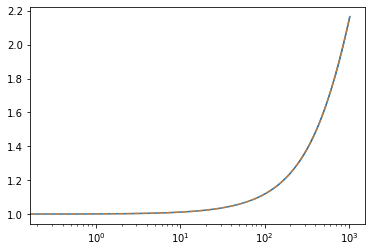

In [187]:
def pnt_Ff_grid(i_w, i_y):
    return data[i_y][i_w][2]+1j*data[i_y][i_w][3]

fs = np.arange(0, 1024, 0.25)
ml = 12
yl = 0.15
wfs = wf(fs, ml)
Ffs1 = pnt_Fw_eff_map(wfs, yl)
Ffs2 = Ff_grid_opt_mod(fs, ml, yl)

plt.plot(fs, np.abs(Ffs2))
plt.plot(fs, np.abs(Ffs1), linestyle='dashed', alpha=0.7)
# plt.plot(fs, np.abs(Ffs1-Ffs2), linestyle='solid', c='black', alpha=0.7)
# plt.xlim(0.01, 300)
plt.xscale('log')

## Error in Grid analysis over the parameter space

In [179]:
mls = np.logspace(1, 5, 10)
yls = np.logspace(-2, np.log10(5), 10)

In [180]:
mls, yls

(array([1.00000000e+01, 2.78255940e+01, 7.74263683e+01, 2.15443469e+02,
        5.99484250e+02, 1.66810054e+03, 4.64158883e+03, 1.29154967e+04,
        3.59381366e+04, 1.00000000e+05]),
 array([0.01      , 0.01994737, 0.03978974, 0.07937005, 0.15832235,
        0.31581138, 0.62996052, 1.25660531, 2.50659661, 5.        ]))

In [181]:
fs = np.arange(0, 1024, 0.05)
t1 = time.time()
grid_err = []
for ml in mls:
    for yl in yls:
        clear_output(True)
        wfs = wf(fs, ml)
        Ffs1 = pnt_Fw_eff_map(wfs, yl)
        Ffs2 = Ff_grid_opt_mod(fs, ml, yl)
        grid_err.append([ml, yl, np.max(np.abs((Ffs2 - Ffs1))/np.abs(Ffs1)),\
                         np.mean(np.abs((Ffs2 - Ffs1))/np.abs(Ffs1))])
        print('Progress: {}%'.format(100*len(grid_err)/(len(mls)*len(yls))))
t2 = time.time()
print('Total Time: {:4f}s'.format(t2-t1))

Progress: 100.0%
Total Time: 423.907235s


In [182]:
grid_err = np.array(grid_err, dtype=np.float64)
np.savetxt('grid_err_check_re1p0_hw.dat', grid_err)

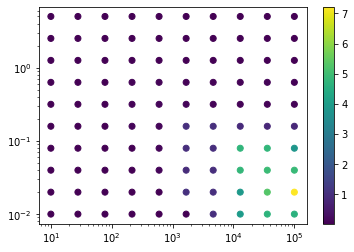

In [185]:
grid_err = np.loadtxt('grid_err_check_re1p0_hw.dat')
err_data = grid_err #grid_err[grid_err[:,0]<1e5]
# max_errs = 
plt.scatter(err_data[:,0], err_data[:,1], c = err_data[:,2])
plt.colorbar()
plt.xscale('log')
plt.yscale('log')

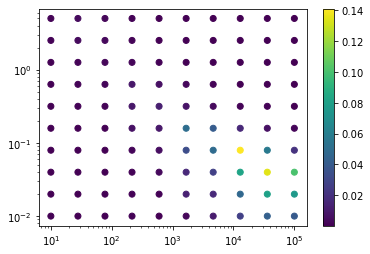

In [186]:
err_data = grid_err #grid_err[grid_err[:,0]<1e5]
# max_errs = 
plt.scatter(err_data[:,0], err_data[:,1], c = err_data[:,3])
plt.colorbar()
plt.xscale('log')
plt.yscale('log')

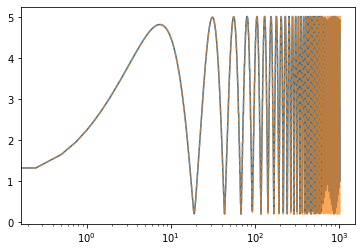

In [84]:
def pnt_Ff_grid(i_w, i_y):
    return data[i_y][i_w][2]+1j*data[i_y][i_w][3]

fs = np.arange(0, 1024, 0.25)
ml, yl = 12915.496650148827, 0.07937005259840996
wfs = wf(fs, ml)
Ffs1 = pnt_Fw_eff_map(wfs, yl)
Ffs2 = Ff_grid_opt_mod(fs, ml, yl)

plt.plot(fs, np.abs(Ffs2))
plt.plot(fs, np.abs(Ffs1), linestyle='dashed', alpha=0.7)
# plt.plot(fs, np.abs(Ffs1-Ffs2), linestyle='solid', c='black', alpha=0.7)
# plt.xlim(0.01, 300)
plt.xscale('log')

In [85]:
max(np.abs(Ffs2-Ffs1))

0.950406838882024

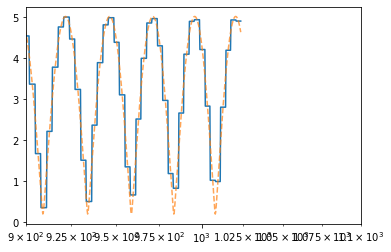

In [101]:
plt.plot(fs, np.abs(Ffs2))
plt.plot(fs, np.abs(Ffs1), linestyle='dashed', alpha=0.7)
# plt.plot(fs, np.abs(Ffs1-Ffs2), linestyle='solid', c='black', alpha=0.7)
plt.xlim(900, 1100)
plt.xscale('log')

In [99]:
yss = [np.arange(1e-2, 1e-1, 1e-5), np.arange(1e-1, 1e-0, 1e-4), np.arange(1e0, 2e0, 1e-3),\
      np.arange(2e0, 5e0+1e-2, 1e-2)]
ys = np.concatenate(yss)
lenyss = [len(yss[i]) for i in range(len(yss))]
yls = [1e-2, 1e-1, 1e-0, 2e0]
dys = [1e-5, 1e-4, 1e-3, 1e-2]

wss = [np.arange(1e-4, 1e-3, 1e-6),
np.arange(1e-3, 1e-2, 1e-5),
np.arange(1e-2, 1e-1, 1e-4),
np.arange(1e-1, 1e-0, 1e-3),
np.arange(1e-0, 1e1, 1e-2),
np.arange(1e1, 1e2, 1e-1),
np.arange(1e2, 1e3, 1e0),
np.arange(1e3, 1e4+5e0, 5e0)]
ws = np.concatenate(wss)
lenwss = [len(wss[i]) for i in range(len(wss))]
wls = [1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3]
dws = [1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1e0, 5e0]

y_w_grid = []
for y in ys:
    wc = wc_geo_re1p0(y)
    tmp_ws = ws[ws <= 1.1*wc]
    y_w_grid.append([y, tmp_ws])
    
y_w_grid = np.array(y_w_grid, dtype=object)      

print('ys: ({:.3f}, {:.3f}), len(ys)={}'.format(ys[0], ys[-1], len(ys)))
print('ws: ({:.4f}, {:2f}), max_len(ws)={}'.format(ws[0], ws[-1], len(ws)))
print('\nGrid Size = {}'.format(len(np.concatenate(y_w_grid[:,1]))))

ys: (0.010, 5.000), len(ys)=19301
ws: (0.0001, 10000.000000), max_len(ws)=8102

Grid Size = 114542330


In [98]:
yss = [np.arange(1e-2, 1e-1, 1e-5), np.arange(1e-1, 1e-0, 1e-4), np.arange(1e0, 2e0, 1e-3),\
      np.arange(2e0, 5e0+1e-2, 1e-2)]
ys = np.concatenate(yss)
lenyss = [len(yss[i]) for i in range(len(yss))]
yls = [1e-2, 1e-1, 1e-0, 2e0]
dys = [1e-5, 1e-4, 1e-3, 1e-2]

wss = [np.arange(1e-4, 1e-3, 1e-6),
np.arange(1e-3, 1e-2, 1e-5),
np.arange(1e-2, 1e-1, 1e-4),
np.arange(1e-1, 1e-0, 1e-3),
np.arange(1e-0, 1e1, 1e-2),
np.arange(1e1, 1e2, 1e-1),
np.arange(1e2, 1e3, 5e-1),
np.arange(1e3, 1e4+1e0, 1e0)]
ws = np.concatenate(wss)
lenwss = [len(wss[i]) for i in range(len(wss))]
wls = [1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3]
dws = [1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 5e-1, 1e0]

y_w_grid = []
for y in ys:
    wc = wc_geo_re1p0(y)
    tmp_ws = ws[ws <= 1.1*wc]
    y_w_grid.append([y, tmp_ws])
    
y_w_grid = np.array(y_w_grid, dtype=object)      

print('ys: ({:.3f}, {:.3f}), len(ys)={}'.format(ys[0], ys[-1], len(ys)))
print('ws: ({:.4f}, {:2f}), max_len(ws)={}'.format(ws[0], ws[-1], len(ws)))
print('\nGrid Size = {}'.format(len(np.concatenate(y_w_grid[:,1]))))

ys: (0.010, 5.000), len(ys)=19301
ws: (0.0001, 10004.000000), max_len(ws)=16206

Grid Size = 158259967


In [100]:
3.8*158259967/114542330

5.2503548216628735